In [245]:
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, pairwise
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import torch
import numpy as np
import os
from train import *
from net.spherenet import SphereNet
from net.pfe import PFE
from net.resnet import *
from utils import *
from dataset.utils import *
from dataset.transform import *

In [246]:
def similarity_score(x1, x2, metric):
    func = {
        'cosine' : pairwise.cosine_similarity,   # embedding
        'euclidean' : pairwise.euclidean_distances, # mu
        'mls' : mls_distance   # mu, log_sigma
    }
    
    if metric!='mls':
        if type(x1) is tuple:
            x1 = x1[0].cpu()
        if type(x2) is tuple:
            x2 = x2[0].cpu()
    return func[metric](x1, x2)

In [ ]:
def evaluate_pair(model, dataset, metric='cosine', threshold=None):
    model.to(device)
    model.eval()
    with torch.no_grad():
        sim_scores = []
        labels = []
        img1s = []
        img2s = []
        for img1, img2, label in dataset:
            img1s.append(img1.to(device).unsqueeze(dim=0))
            img2s.append(img2.to(device).unsqueeze(dim=0))
            labels.append(label)
        img1s = torch.cat(img1s, dim=0)
        img2s = torch.cat(img2s, dim=0)
        x1 = model(img1s.to(device)).cpu()
        x2 = model(img2s.to(device)).cpu()
        sim_score = similarity_score(x1,x2,metric)
        sim_scores.append(sim_score)
    sim_scores = np.array(sim_scores)
    labels = np.array(labels)
    
    # choose threshold with most accuracies
    label_vec = (sim_scores>0.5) == labels
    if threshold != None:
        label_vec = (sim_scores>threshold) == labels
        far, tar, thresholds = roc_curve(np.repeat(labels, sim_score.shape[0]), sim_score.reshape(-1))
        # Calculate AUC using scikit-learn
        auc_score = auc(far, tar)
        return far, tar, auc_score
    
#     score_pos = sim_scores[label_vec==True]
#     thresholds = np.sort(score_pos)
    thresholds = np.array([i/4 for i in range(21)])
    accuracies = np.zeros(np.size(thresholds))
    for i, threshold in enumerate(thresholds):
        pred_vec = sim_scores>=threshold
        accuracies[i] = np.mean(pred_vec==labels)

    argmax = np.argmax(accuracies)
    accuracy = accuracies[argmax]
    threshold = np.mean(thresholds[accuracies==accuracy])
    return accuracy, threshold

In [ ]:
def evaluate(model, dataset):
    model.to(device)
    model.eval()

    sim_scores = []
    labels = []

    # Move the model to evaluation mode and set the data types once
    with torch.no_grad():
        for data in dataset:
            img = data[0].unsqueeze(0).type(torch.float32)
            img2 = data[1].unsqueeze(0).type(torch.float32)
            labels.append(data[2])

        # Batch processing: Stack the images for efficient computation
        img = torch.cat([sample[0].unsqueeze(0) for sample in dataset]).to(device).type(torch.float32)
        img2 = torch.cat([sample[1].unsqueeze(0) for sample in dataset]).to(device).type(torch.float32)

        # Compute the representations for all samples in the dataset
        x = model(img).cpu()
        y = model(img2).cpu()

        # Calculate similarity scores for all pairs in the dataset
        sim_scores = similarity_score(x, y, 'cosine').diagonal()

    return labels, sim_scores


In [ ]:
def plot_roc(far, tar):
    auc_score=auc(far,tar)
    plt.plot(far, tar, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def tar_at_far(tar,far):
    print(f'''TAR@FAR:
    1%: {np.interp(.1,   far,tar):.4f}
  0.1%: {np.interp(.01,  far,tar):.4f}
 0.01%: {np.interp(.001, far,tar):.4f}
0.001%: {np.interp(.0001,far,tar):.4f}''')

In [ ]:
def accuracy(labels, sim_scores, thresholds):
    accuracy_scores = []
    for thresh in thresholds:
        accuracy_scores.append(metrics.accuracy_score(labels, [m > thresh for m in sim_scores]))

    accuracies = np.array(accuracy_scores)
    max_accuracy = accuracies.max() 
    max_accuracy_threshold =  thresholds[accuracies.argmax()]
    print(f'Accuracy: {max_accuracy}, Threshold: {max_accuracy_threshold}')

In [210]:
def average_precision_at_k(y_true, y_pred, k):
    # Sort predicted scores in descending order and get corresponding true labels
    sorted_indices = np.argsort(y_pred)[::-1][:k]
    y_true = np.asarray(y_true)[sorted_indices]
    print(y_true)

    # Calculate precision at each position up to k
    precision_at_k = np.cumsum(y_true) / (np.arange(k) + 1)
    print(precision_at_k)

    # Calculate average precision
    average_precision = np.sum(precision_at_k * y_true) / min(k, sum(y_true))

    return average_precision

def map_at_k(y_true, y_pred, k):
    num_samples = len(y_true)
    map_at_r = 0.0

    for i in range(num_samples):
        ap = average_precision_at_k(y_true[i], y_pred[i], k)
        map_at_r += ap

    map_at_r /= num_samples
    return map_at_r

In [ ]:
def visualize(labels, sim_scores):
    far,tar,thresholds=roc_curve(labels,sim_scores)
    plot_roc(far,tar)
    tar_at_far(tar,far)
    accuracy(labels, sim_scores, thresholds)
    print(f'MAP@10: {map_at_k(labels, sim_scores, 10)}')

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [130]:
test_dataset = datasets.LFWPairs(
    root='./data',
    split='test',
    download=True,
    transform=transforms.Compose([
        transforms.CenterCrop(125),
        transforms.Resize((100,100)),
        transforms.ToTensor(),
    ])
)

Files already downloaded and verified


In [131]:
model = get_model('resnet50')

In [132]:
labels,sim_scores = evaluate(model,test_dataset)

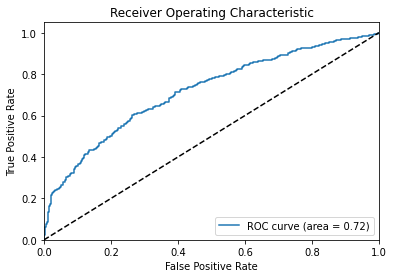

TAR@FAR:
    1%: 0.3620
  0.1%: 0.0880
 0.01%: 0.0240
0.001%: 0.0240


In [133]:
far,tar,thresholds=roc_curve(labels,sim_scores)
plot_roc(far,tar)
tar_at_far(tar,far)

In [274]:
test_dataset = datasets.LFWPairs(
    root='./data',
    split='test',
    download=True,
    transform=transforms.Compose([
        transforms.CenterCrop(125),
        transforms.Resize((100,100)),
        transforms.ToTensor(),
    ])
)

Files already downloaded and verified


In [276]:
model = torch.load('./saved_models/PA.ptm')

In [137]:
labels,sim_scores = evaluate(model,test_dataset)

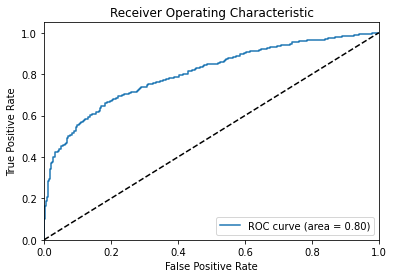

TAR@FAR:
    1%: 0.5560
  0.1%: 0.2080
 0.01%: 0.1000
0.001%: 0.1000
Accuracy: 0.738, Threshold: 0.8785049319267273


In [138]:
visualize(labels,sim_scores)

In [348]:
test_dataset = datasets.LFWPairs(
    root='./data',
    split='test',
    download=True,
    transform=transforms.Compose([
        transforms.CenterCrop(125),
        AutoContrast(),
        transforms.Resize((100,100)),
        MedianUnsharpFilter(size=1,amount=1),
        MedianHSVFilter(method='sv',size=3),
        transforms.ToTensor(),
    ])
)

Files already downloaded and verified


In [349]:
model = torch.load('./saved_models/PA+Crop(125)+Random+AutoContrast+MedianUnsharp(size=1,amount=1)+MedianHSV(method=sv,size=3).ptm')

In [350]:
labels,sim_scores = evaluate(model,test_dataset)

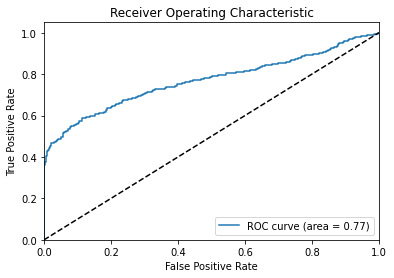

TAR@FAR:
    1%: 0.5660
  0.1%: 0.4300
 0.01%: 0.3620
0.001%: 0.3620
Accuracy: 0.736, Threshold: 0.9020345211029053


In [351]:
visualize(labels,sim_scores)

In [344]:
test_dataset = datasets.LFWPairs(
    root='./data',
    split='test',
    download=True,
    transform=transforms.Compose([
        transforms.CenterCrop(125),
        AutoContrast(),
        transforms.Resize((100,100)),
        transforms.ToTensor(),
    ])
)

Files already downloaded and verified


In [345]:
model = torch.load('./saved_models/PA+Crop(125)+Random+AutoContrast.ptm')

In [346]:
labels,sim_scores = evaluate(model,test_dataset)

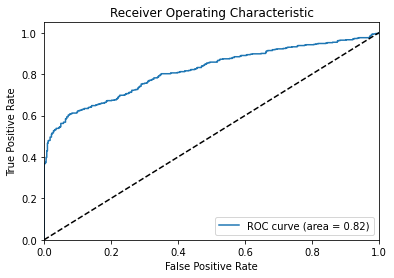

TAR@FAR:
    1%: 0.6220
  0.1%: 0.4660
 0.01%: 0.3680
0.001%: 0.3680
Accuracy: 0.765, Threshold: 0.8772996664047241


In [347]:
visualize(labels,sim_scores)